# 注意力汇聚：Nadaraya-Watson 核回归

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

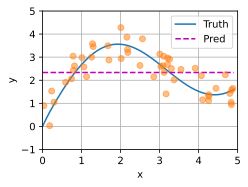

In [6]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

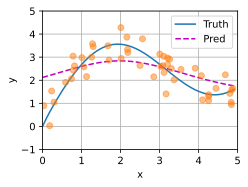

In [8]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

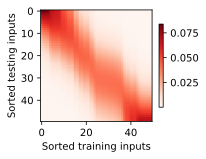

In [10]:
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

In [12]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [14]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [26]:
class NWKernelRegression(nn.Module):
    # 定义一个名为 NWKernelRegression 的类，它继承自 nn.Module，这是 PyTorch 中所有神经网络模块的基类
    def __init__(self, **kwargs):
        # 类的初始化方法，当创建这个类的实例时会自动调用
        super().__init__(**kwargs)
        # 调用父类 nn.Module 的初始化方法，确保父类的初始化逻辑被正确执行
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
        # 定义一个可训练的参数 w，初始值是一个随机的标量（形状为 (1,)），requires_grad=True 表示这个参数需要在训练过程中进行梯度计算和更新

    def forward(self, queries, keys, values):
        # 定义前向传播方法，当调用这个类的实例时会自动调用此方法，输入参数分别是查询（queries）、键（keys）和值（values）
        queries = queries.repeat_interleave(keys.shape[1]).reshape(
            (-1, keys.shape[1]))
        # 将 queries 中的每个元素重复 keys.shape[1] 次，然后重新调整形状为 (-1, keys.shape[1])，这样做是为了让 queries 能够与 keys 进行逐元素的计算
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # 计算注意力权重，首先计算 queries 和 keys 的差值，乘以可训练参数 w，然后取平方并除以 2，前面加负号，最后通过 softmax 函数将结果转换为概率分布，dim=1 表示在第 1 个维度上进行 softmax 操作
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)
        # 使用 torch.bmm 进行批量矩阵乘法，将注意力权重扩展一个维度（unsqueeze(1)），将 values 也扩展一个维度（unsqueeze(-1)），然后进行矩阵乘法，最后将结果重新调整形状为一维向量返回

### 原理和记忆方法
#### 原理
这个类实现了核回归的注意力机制。核回归是一种非参数的回归方法，通过计算查询点与已知数据点之间的相似度（这里使用高斯核）来确定每个数据点的权重，然后根据这些权重对相应的值进行加权求和得到预测结果。

#### 记忆方法
- `__init__` 方法：记住要调用父类的初始化方法，并且定义可训练的参数。
- `forward` 方法：
    1. 对 queries 进行重复和形状调整，使其与 keys 匹配。
    2. 计算注意力权重，核心是使用高斯核函数和 softmax 函数。
    3. 使用批量矩阵乘法将注意力权重和 values 相乘得到最终结果。


In [18]:
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))

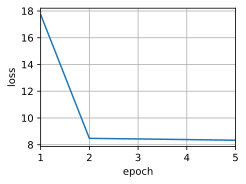

In [20]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

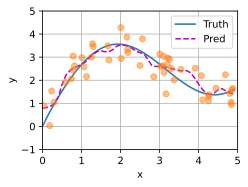

In [22]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

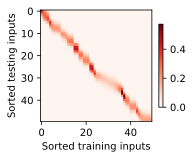

In [24]:
d2l.show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')



在核回归（如`NWKernelRegression`）中，曲线在注意力权重较大的区域变得更不平滑，主要与模型的局部拟合特性和高斯核的参数化有关。以下是详细解释：

---

### 1. **注意力权重的本质：局部依赖**
   - 注意力权重（`attention_weights`）表示模型对不同数据点的依赖程度。权重越大，模型在预测时越依赖对应的`keys`和`values`。
   - 在高斯核的计算中，权重由`-((queries - keys) * self.w)**2 / 2`决定。当`queries`与`keys`的距离较小时（即局部区域），指数项的值会更大，经过`softmax`后，这些局部点的权重会显著增加。
   - **直观理解**：模型在注意力权重较大的区域，会更“关注”附近的少数数据点，而忽略远处的数据点。

---

### 2. **可训练参数`w`的作用：控制局部拟合的粒度**
   - 参数`w`（在`__init__`中定义）放大了`queries`与`keys`之间的距离差异。`w`越大，高斯核的“带宽”越小，模型对局部细节的敏感度越高。
   - 当`w`较大时，即使`queries`与`keys`的距离稍有变化，权重也会剧烈变化。这导致模型在局部区域对数据点的拟合更加“尖锐”，从而捕捉到更多细微的波动。
   - **类比**：`w`相当于一个“放大镜”，`w`越大，放大镜的倍数越高，模型能看到数据中的更多细节，但也会放大噪声和局部变化，导致曲线不平滑。

---

### 3. **不平滑的数学解释**
   - 核回归的预测结果是对`values`的加权平均（公式：`torch.bmm(attention_weights, values)`）。当注意力权重在局部区域变化剧烈时，加权平均的结果会更贴近局部数据的波动。
   - 例如，假设在某个区域，两个相邻的`queries`点对附近`keys`的注意力权重差异很大，那么预测结果在这两个点上的变化也会很大，导致曲线出现陡峭的上升或下降，即不平滑。

---

### 4. **与平滑性的权衡**
   - 核回归的平滑性通常由核的带宽（此处由`w`间接控制）决定。带宽越大（`w`越小），模型对远处数据的平均作用越强，曲线越平滑；带宽越小（`w`越大），模型越关注局部，曲线越不平滑。
   - 在`NWKernelRegression`中，`w`是可训练的参数。模型会根据数据调整`w`，在需要捕捉细节的区域增大`w`，从而导致局部曲线不平滑。

---

### 总结
曲线在注意力权重较大的区域变得更不平滑，是因为模型在这些区域更依赖局部数据点，并且可训练参数`w`放大了局部距离的影响，使得加权平均的结果更贴近局部数据的细微变化。要控制平滑性，可以通过调整`w`的初始值或在训练中限制其取值范围。

# 注意力打分函数

In [47]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [31]:
import torch
import torch.nn as nn
# 假设 d2l 是一个自定义的深度学习工具包，提供了 sequence_mask 函数
# 这里我们不详细展开 d2l 的实现，仅假设它存在且有相应功能
# 你可以根据实际情况替换为其他实现

def masked_softmax(X, valid_lens):
    """
    通过在最后一个轴上遮蔽元素来执行 softmax 操作。

    参数:
    X (torch.Tensor): 输入的张量，通常是需要进行 softmax 操作的数据。
    valid_lens (torch.Tensor 或 None): 有效长度的张量，用于指定每个样本的有效元素数量。
                                       如果为 None，则不进行遮蔽，直接进行 softmax 操作。

    返回:
    torch.Tensor: 经过遮蔽和 softmax 操作后的张量。
    """
    # 如果 valid_lens 为 None，说明不需要进行遮蔽操作，直接对输入 X 在最后一个维度上进行 softmax 操作
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        # 获取输入张量 X 的形状
        shape = X.shape
        # 如果 valid_lens 是一维张量
        if valid_lens.dim() == 1:
            # 将 valid_lens 中的每个元素重复 shape[1] 次，这样可以保证每个样本的有效长度信息正确对应到 X 的元素上
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            # 如果 valid_lens 不是一维张量，将其展平为一维张量
            valid_lens = valid_lens.reshape(-1)
        # 使用 d2l.sequence_mask 函数对 X 进行遮蔽操作
        # 首先将 X 重塑为二维张量，形状为 (-1, shape[-1])
        # valid_lens 作为有效长度的指示
        # 将无效位置的值设置为 -1e6，这样在后续的 softmax 操作中，这些值对应的概率会趋近于 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        # 将遮蔽后的 X 重新调整回原来的形状
        # 然后在最后一个维度上进行 softmax 操作并返回结果
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [33]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))


tensor([[[0.5414, 0.4586, 0.0000, 0.0000],
         [0.4920, 0.5080, 0.0000, 0.0000]],

        [[0.2315, 0.3290, 0.4395, 0.0000],
         [0.4476, 0.2436, 0.3088, 0.0000]]])

In [35]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))


tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2918, 0.3006, 0.4076, 0.0000]],

        [[0.7005, 0.2995, 0.0000, 0.0000],
         [0.1770, 0.2592, 0.3439, 0.2200]]])

In [21]:
import torch
import torch.nn as nn

# 假设前面定义的 masked_softmax 函数存在
# 这里使用它来处理注意力分数的遮蔽和 softmax 操作

class AdditiveAttention(nn.Module):
    """
    加性注意力机制类，继承自 PyTorch 的 nn.Module。
    加性注意力用于计算查询（queries）和键（keys）之间的注意力权重，
    然后使用这些权重对值（values）进行加权求和。
    """
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        """
        类的初始化方法，用于创建加性注意力机制所需的线性层和 dropout 层。

        参数:
        key_size (int): 键的特征维度。
        query_size (int): 查询的特征维度。
        num_hiddens (int): 隐藏层的维度，用于中间计算。
        dropout (float): dropout 概率，用于防止过拟合。
        **kwargs: 其他关键字参数，传递给父类的初始化方法。
        """
        # 调用父类 nn.Module 的初始化方法
        super(AdditiveAttention, self).__init__(**kwargs)
        # 创建一个线性层 W_k，将键从 key_size 维度映射到 num_hiddens 维度，不使用偏置
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        # 创建一个线性层 W_q，将查询从 query_size 维度映射到 num_hiddens 维度，不使用偏置
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        # 创建一个线性层 w_v，将中间特征从 num_hiddens 维度映射到 1 维度，不使用偏置
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        # 创建一个 dropout 层，用于在训练过程中随机丢弃部分神经元，防止过拟合
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        """
        前向传播方法，用于计算加性注意力的输出。

        参数:
        queries (torch.Tensor): 查询张量，形状通常为 (batch_size, num_queries, query_size)。
        keys (torch.Tensor): 键张量，形状通常为 (batch_size, num_keys, key_size)。
        values (torch.Tensor): 值张量，形状通常为 (batch_size, num_keys, value_size)。
        valid_lens (torch.Tensor 或 None): 有效长度的张量，用于指定每个样本的有效元素数量。
                                           如果为 None，则不进行遮蔽，直接进行 softmax 操作。

        返回:
        torch.Tensor: 经过加性注意力加权求和后的输出张量，形状为 (batch_size, num_queries, value_size)。
        """
        # 通过线性层 W_q 和 W_k 分别对查询和键进行线性变换
        # 变换后的形状分别为 (batch_size, num_queries, num_hiddens) 和 (batch_size, num_keys, num_hiddens)
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在查询张量的第 2 个维度上增加一个维度，形状变为 (batch_size, num_queries, 1, num_hiddens)
        # 在键张量的第 1 个维度上增加一个维度，形状变为 (batch_size, 1, num_keys, num_hiddens)
        # 然后将它们相加，得到特征张量 features，形状为 (batch_size, num_queries, num_keys, num_hiddens)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # 对特征张量应用双曲正切激活函数 tanh，将其值映射到 (-1, 1) 区间
        features = torch.tanh(features)
        # 通过线性层 w_v 将特征张量从 num_hiddens 维度映射到 1 维度
        # 然后去掉最后一个维度，得到注意力分数张量 scores，形状为 (batch_size, num_queries, num_keys)
        scores = self.w_v(features).squeeze(-1)
        # 使用 masked_softmax 函数对注意力分数进行遮蔽和 softmax 操作，得到注意力权重
        # 注意力权重的形状为 (batch_size, num_queries, num_keys)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # 对注意力权重应用 dropout 操作，随机丢弃部分权重
        # 然后使用批量矩阵乘法 bmm 将注意力权重和值进行加权求和
        # 得到最终的输出张量，形状为 (batch_size, num_queries, value_size)
        return torch.bmm(self.dropout(self.attention_weights), values)


### 原理和记忆方法

#### 原理
加性注意力机制通过将查询和键分别进行线性变换，然后将它们相加得到中间特征。接着对中间特征应用双曲正切激活函数，再通过一个线性层将其映射到一维，得到注意力分数。最后使用 `masked_softmax` 函数将注意力分数转换为注意力权重，对值进行加权求和得到最终输出。这种机制可以有效地捕捉查询和键之间的复杂关系，尤其是当查询和键的维度不同时。

#### 记忆方法
1. **初始化部分**：记住要创建三个线性层 `W_k`、`W_q` 和 `w_v` 以及一个 `dropout` 层。
2. **前向传播部分**：
    - 对查询和键进行线性变换。
    - 通过扩展维度和相加得到中间特征。
    - 应用 `tanh` 激活函数。
    - 计算注意力分数。
    - 使用 `masked_softmax` 得到注意力权重。
    - 应用 `dropout` 并对值进行加权求和。


In [39]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10,
                                                       4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

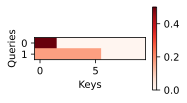

In [41]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [43]:
import torch
import torch.nn as nn
import math

# 假设前面定义的 masked_softmax 函数存在
# 这里使用它来处理注意力分数的遮蔽和 softmax 操作

class DotProductAttention(nn.Module):
    """
    缩放点积注意力机制类，继承自 PyTorch 的 nn.Module。
    缩放点积注意力用于计算查询（queries）和键（keys）之间的注意力权重，
    然后使用这些权重对值（values）进行加权求和。
    """
    def __init__(self, dropout, **kwargs):
        """
        类的初始化方法，用于创建缩放点积注意力机制所需的 dropout 层。

        参数:
        dropout (float): dropout 概率，用于防止过拟合。
        **kwargs: 其他关键字参数，传递给父类的初始化方法。
        """
        # 调用父类 nn.Module 的初始化方法
        super(DotProductAttention, self).__init__(**kwargs)
        # 创建一个 dropout 层，用于在训练过程中随机丢弃部分神经元，防止过拟合
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        """
        前向传播方法，用于计算缩放点积注意力的输出。

        参数:
        queries (torch.Tensor): 查询张量，形状通常为 (batch_size, num_queries, d)。
        keys (torch.Tensor): 键张量，形状通常为 (batch_size, num_keys, d)。
        values (torch.Tensor): 值张量，形状通常为 (batch_size, num_keys, value_size)。
        valid_lens (torch.Tensor 或 None): 有效长度的张量，用于指定每个样本的有效元素数量。
                                           如果为 None，则不进行遮蔽，直接进行 softmax 操作。

        返回:
        torch.Tensor: 经过缩放点积注意力加权求和后的输出张量，形状为 (batch_size, num_queries, value_size)。
        """
        # 获取查询张量的最后一个维度的大小，即查询和键的特征维度 d
        d = queries.shape[-1]
        # 计算查询和键的点积，得到注意力分数。
        # 首先使用 keys.transpose(1, 2) 将键张量的第 1 维和第 2 维交换，
        # 然后使用 torch.bmm 进行批量矩阵乘法，得到形状为 (batch_size, num_queries, num_keys) 的分数矩阵。
        # 最后除以 math.sqrt(d) 进行缩放，避免点积结果过大导致梯度消失或爆炸。
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        # 使用 masked_softmax 函数对注意力分数进行遮蔽和 softmax 操作，得到注意力权重
        # 注意力权重的形状为 (batch_size, num_queries, num_keys)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # 对注意力权重应用 dropout 操作，随机丢弃部分权重
        # 然后使用批量矩阵乘法 bmm 将注意力权重和值进行加权求和
        # 得到最终的输出张量，形状为 (batch_size, num_queries, value_size)
        return torch.bmm(self.dropout(self.attention_weights), values)


### 原理和记忆方法

#### 原理
缩放点积注意力机制通过计算查询和键的点积来衡量它们之间的相似度，得到注意力分数。为了避免点积结果过大导致梯度消失或爆炸，将点积结果除以查询维度的平方根进行缩放。然后使用 `masked_softmax` 函数将注意力分数转换为注意力权重，对值进行加权求和得到最终输出。这种机制计算效率高，在 Transformer 等模型中被广泛使用。

#### 记忆方法
1. **初始化部分**：记住创建一个 `dropout` 层。
2. **前向传播部分**：
    - 获取查询的维度 `d`。
    - 计算查询和键的点积并除以 `math.sqrt(d)` 进行缩放，得到注意力分数。
    - 使用 `masked_softmax` 得到注意力权重。
    - 应用 `dropout` 并对值进行加权求和。


In [49]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

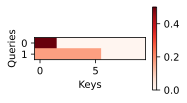

In [51]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

# Bahdanau 注意力

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [29]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens=num_hiddens, dropout=dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights


In [31]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape


C:\Users\29229\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

In [35]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights:
                if param.ndim == 2:
                    nn.init.xavier_uniform_(param)
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = d2l.MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = d2l.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            # 调试信息
            print("dec_input shape:", dec_input.shape)
            # 前向传播
            output = net(X, dec_input, X_valid_len)
            # 调试信息
            print("output type:", type(output))
            print("output shape:", output.shape if isinstance(output, torch.Tensor) else [o.shape for o in output])
            # 解包输出
            if isinstance(output, tuple):
                Y_hat, _ = output
            else:
                Y_hat = output
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            optimizer.step()
            metric.add(l.sum(), l.numel())
        if (epoch + 1) % 10 == 0:
            print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')
        animator.add(epoch + 1, (metric[0] / metric[1],))

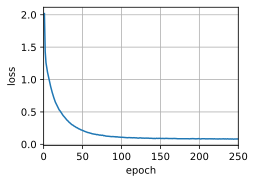

In [37]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [39]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [41]:
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weight_seq], 0).reshape(
        (1, 1, -1, num_steps))

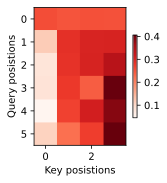

In [43]:
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key posistions', ylabel='Query posistions')